
<a id='covid-sde'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Modelando Choques no COVID 19 com Equações Diferenciais Estocásticas

## Conteúdo

- [Modelando Choques no COVID 19 com Equações Diferenciais Estocásticas](#Modelando-Choques-no-COVID-19-com-Equações-Diferenciais-Estocásticas)  
  - [Resumo](#Resumo)  
  - [O Modelo SIR/SIRD Básico](#O-Modelo-SIR/SIRD-Básico)  
  - [Introdução as SDEs](#Introdução-as-SDEs)  
  - [Terminando o Lockdown](#Terminando-o-Lockdown)  
  - [Reinfecção](#Reinfecção)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

## Resumo

Co-autoria com Chris Rackauckas

Esta aula continua a análise da pandemia COVID-19 estabelecida nesta [aula](https://julia.quantecon.org/seir_model.html).

Como antes, o modelo é inspirado em: 
* Notas de [Andrew Atkeson](https://sites.google.com/site/andyatkeson/) e [NBER Working Paper No. 26867](https://www.nber.org/papers/w26867);
* [Estimativa e previsão de cenários de doenças para COVID-19 com um modelo SIR](https://www.nber.org/papers/w27335) por Andrew Atkeson, Karen Kopecky e Tao Zha;
* [Estimativa e simulação de um modelo SIRD de COVID-19 para muitos países, estados e cidades](https://www.nber.org/papers/w27128) por Jesús Fernández-Villaverde e Charles I. Jones
* Outras variações do modelo SIR clássico em Julia [aqui](https://github.com/epirecipes/sir-julia).

Aqui, estendemos o modelo para incluir choques agregados relevantes para as políticas.

### Processos Estocásticos em Tempo Contínuo

Em tempo contínuo, há uma distinção importante entre aleatoriedade que leva a caminhos contínuos e aquela que é ([quase certamente contínua à direita](https://en.wikipedia.org/wiki/C%C3%A0dl%C3%A0g)) e que salta em seus caminhos. O mais tratável deles inclui a teoria dos [Processos de Levy](https://en.wikipedia.org/wiki/L%C3%A9vy_process).

Entre as características atraentes dos processos de Levy é que eles se encaixam bem nos tipos de técnicas de modelagem de Markov que os economistas tendem a usar em tempo discreto e geralmente cumprem a mensurabilidade necessária para calcular os valores presentes descontados esperados.

Ao contrário do tempo discreto, onde um modelador tem licença para ser criativo, as regras dos processos estocásticos de tempo contínuo são muito mais rígidas. Pode-se mostrar que o ruído de um processo de Levy pode ser decomposto em duas porções:

1. [Processos Weiner](https://en.wikipedia.org/wiki/Wiener_process) (conhecido como Movimento Browniano) que leva a uma equação de difusão e é o único processo de Levy em tempo contínuo com caminhos contínuos;
2. [Processos de Poisson](https://en.wikipedia.org/wiki/Poisson_point_process) com uma taxa de chegada de saltos na variável.


Todos os outros processos de Levy podem ser representados por esses blocos de construção (por exemplo, um [processo de difusão](https://en.wikipedia.org/wiki/Diffusion_process), como o movimento browniano geométrico é uma transformação de um processo de Weiner, um [salto de difusão ](https://en.wikipedia.org/wiki/Jump_diffusion#In_economics_and_finance) é um processo de difusão com uma chegada de saltos de Poisson, e uma cadeia de markov de tempo contínuo (CMTC) é um processo de Poisson que salta entre um número finito de estados).

Nesta aula, examinaremos choques causados por transformações do movimento browniano, como a Equação Diferencial Estocástica prototípica (SDE).

### Configuração

In [1]:
using InstantiateFromURL
# opcionalmente, adicione argumentos para forçar a instalação: instanciar = true, pré-compilar = true
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0")

In [2]:
using LinearAlgebra, Statistics, Random, SparseArrays

Adicionalmente, iremos explorar pacotes dentro do [ecossistema SciML](https://github.com/SciML/) e outros abordados em aulas anteriores.

In [3]:
using OrdinaryDiffEq, StochasticDiffEq
using Parameters, Plots
gr(fmt=:png);

## O Modelo SIR/SIRD Básico

Para demonstrar outro [modelo compartimentado](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Elaborations_on_the_basic_SIR_model), vamos alterar o modelo [SEIR anterior](https://julia.quantecon.org/seir_model.html) para remover o estado exposto e gerenciar com mais cuidado o estado de morte, D.

Os estados agora são: suscetível (S), infectado (I), resistente (R) ou morto (D).

Comentários:

- Ao contrário do modelo SEIR anterior, o estado R é apenas para aqueles recuperados, vivos e atualmente resistentes.
- Como antes, partimos do pressuposto de que aqueles que se recuperaram adquiriram imunidade.
- Mais tarde, podemos considerar as transições de R para S se a resistência não for permanente devido à mutação do vírus, etc.

### Taxas de transição

Veja a [aula anterior](https://julia.quantecon.org/seir_model.html), para um desenvolvimento mais detalhado do modelo.

- $ \beta (t) $ é chamado de *taxa de transmissão* ou *taxa de contato efetiva* (a taxa na qual os indivíduos se chocam com outros e os expõem ao vírus;
- $ \gamma $ é chamado de *taxa de resolução* (a taxa na qual as pessoas infectadas se recuperam ou morrem);
- $ \delta (t) \ in [0, 1] $ é a *probabilidade de morte*, e 
- Como antes, parametrizamos novamente como $ R_0 (t): = \beta (t) / \gamma $, onde $ R_0 $ tem interpretação anterior.


Saltando diretamente para as equações em $ s, i, r, d $ já normalizado por $ N $,


<a id='equation-sird'></a>
$$
\begin{aligned}
     d s  & = - \gamma \, R_0 \, s \,  i \, dt
     \\
      d i  & = \left(\gamma \, R_0 \, s \,  i  - \gamma  \, i \right) dt
     \\
     d r  & = (1-\delta) \gamma  \, i \, dt
     \\
     d d  & = \delta  \, \gamma  \, i \, dt
     \\
\end{aligned} \tag{1}
$$

Observe que a notação foi alterada para colocar heuristicamente $ dt $ no lado direito, que será usado ao adicionar os choques estocásticos.

## Introdução as SDEs

Começamos estendendo nosso modelo para incluir a aleatoriedade em $ R_0 (t) $ e então a taxa de mortalidade $ \delta (t) $.

O resultado é um sistema de Equações Diferenciais Estocásticas (SDEs).

### Choques nas taxas de transmissão

Como antes, assumimos que o número de reprodução básico, $ R_0 (t) $, segue um processo com uma reversão para um valor $ \bar {R} _0 (t) $ que poderia ser influenciado pela política. A intuição é que mesmo se o $ \bar {R} _0 (t) $ alvo fosse alterado por distanciamento social / etc., Atrasos no comportamento e na implementação suavizariam a transição, onde $ \eta $ governa a velocidade de $ R_0 (t) $ move-se para $ \bar {R} _0 (t) $.

Além de mudanças na política, a aleatoriedade em $ R_0 (t) $ pode vir de choques no processo $ \beta (t) $. Por exemplo,

- A desinformação nas redes sociais se espalhando de maneira não uniforme;
- Grandes comícios políticos, eleições ou protestos;
- Desvios na implementação e no momento da política de bloqueio entre dados demográficos, locais ou negócios dentro do sistema;
- Agregar choques em abertura / fechamento de indústrias.


Para implementar esses tipos de aleatoriedade, adicionaremos um termo de difusão com uma volatilidade instantânea de $ \sigma \sqrt {R_0} $.

- Esta equação é usada em [Cox-Ingersoll-Ross](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model) e [Heston](https://en.wikipedia.org/wiki/Heston_model) modelos de taxas de juros e volatilidade estocástica.
- A escala por $ \sqrt {R_0} $ garante que o processo permaneça fracamente positivo. A explicação heurística é que a variância dos choques converge para zero quando R₀ vai para zero, permitindo que a deriva para cima domine.
- Veja [aqui](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model#Distribution) para uma descrição heurística de quando o processo é fraca e estritamente positivo.


A notação para este [SDE](https://en.wikipedia.org/wiki/Stochastic_differential_equation#Use_in_probability_and_mathematical_finance) é então


<a id='equation-rsde'> </a>
$$
\begin {aligned}
d R_ {0t} & = \eta (\bar {R} _ {0t} - R_ {0t}) dt + \sigma \sqrt {R_ {0t}} dW_t \\
\end {aligned} \tag {2}
$$

onde $ W $ é o movimento browniano padrão (ou seja, um [Processo Weiner](https://en.wikipedia.org/wiki/Wiener_process).

Heuristicamente, se $ \sigma = 0 $, divida esta equação por $ dt $ e ela aninha a ODE original usada na aula anterior.

Embora não consideremos nenhuma calibração para o parâmetro $ \sigma $, estudos empíricos como [Estimativa e simulação de um modelo SIRD de COVID-19 para muitos países, estados e cidades](https://www.nber.org/papers/w27128) (Figura 6) mostram estimativas de $ R_0 (t) $ altamente voláteis ao longo do tempo.

Mesmo depois que os bloqueios são implementados pela primeira vez, vemos uma variação entre 0,5 e 1,5. Como os países são feitos de cidades interconectadas com tais taxas de contato variáveis, um $ \sigma $ alto parece razoável tanto intuitiva quanto empiricamente.

### Taxas de mortalidade

Ao contrário da aula anterior, iremos avançar para taxas de mortalidade que mudam com o tempo.

A mistura imperfeita de diferentes grupos demográficos pode levar a choques agregados na mortalidade (por exemplo, se uma casa de repouso estiver sob tensão vs. uma escola primária). Esses tipos de mudanças relativamente pequenas podem ser melhor modelados como um processo de caminho contínuo.

Seja $ \delta (t) $ a taxa de mortalidade e, além disso,

- Suponha que a taxa de mortalidade básica seja $ \bar {\delta} $, que atua como a média do processo, revertendo na taxa $ \theta $. Em modelos mais elaborados, isso pode variar com o tempo.
- O termo de difusão tem uma volatilidade $ \xi \sqrt {\delta (1 - \delta)} $.
- À medida que o processo se aproxima de $ \delta = 1 $ ou $ \delta = 0 $, a volatilidade vai para 0, que atua como uma força para permitir a reversão à média para manter o processo dentro dos limites
- Ao contrário do modelo Cox-Ingersoll-Ross bem estudado, não fazemos reivindicações sobre o comportamento de longo prazo desse processo, mas examinaremos o comportamento em uma pequena escala de tempo, então isso não é um problema.


Diante disso, o processo estocástico para a taxa de mortalidade é,


<a id='equation-dmt'> </a>
$$
\begin {aligned}
d \delta_t & = \theta (\bar {\delta} - \delta_t) dt + \xi \sqrt {(\delta_t (1- \delta_t)} d W_t \\
\end {aligned} \tag {3}
$$

Onde o movimento browniano de $ W_t $ é independente do processo anterior.

### Sistema de SDEs

O sistema [(1)](#equation-sird) pode ser escrito na forma vetorial $ x: = [s, i, r, d, R₀, \delta] $ com parâmetro tupla parâmetro tupla $ p: = (\gamma , eta, \sigma, \theta, \xi, \bar {R} _0 (\cdot), \bar {\delta}) $

A forma geral do SDE é.

$$
\begin {aligned}
d x_t & = F (x_t, t; p) dt + G (x_t, t; p) dW
\end {aligned}
$$

Com a deriva,


<a id='equation-dfcvsde'> </a>
$$
F (x, t; p): = \begin {bmatrix}
    - \gamma \, R_0 \, s \, i
    \\
    \gamma \, R_0 \, s \, i - \gamma i
    \\
    (1- \delta) \gamma i
    \\
    \delta \gamma i
    \\
    \eta (\bar {R} _0 (t) - R_0)
    \\
    \theta (\bar {\delta} - \delta)
    \\
\end {bmatrix} \tag {4}
$$

Aqui, é conveniente, mas não necessário, que $ d W $ tenha a mesma dimensão que $ x $. Nesse caso, podemos usar uma matriz quadrada $ G (x, t; p) $ para associar os choques com o $ x $ apropriado (por exemplo, ruído diagonal, ou usando uma matriz de covariância).

Como as duas fontes independentes de movimento browniano afetam apenas os termos $ d R_0 $ e $ d \delta $ (ou seja, a 5ª e 6ª equações), defina a matriz de covariância como


<a id='equation-dg'> </a>
$$
\begin {aligned}
G (x, t) &: = diag \left (\begin {bmatrix} 0 & 0 & 0 & 0 & \sigma \sqrt {R_0} & \xi \sqrt {\delta (1- \delta)} \end {bmatrix} \right)
\end {aligned} \tag {5}
$$

### Implementação

Primeiro, construir $ F $ de [(4)](#equation-dfcvsde) e $ G $ de [(5)](#equation-dg).

In [4]:
function F(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar = p

    return [-γ*R₀*s*i;        # ds/dt
            γ*R₀*s*i - γ*i;   # di/dt
            (1-δ)*γ*i;        # dr/dt
            δ*γ*i;            # dd/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            θ*(δ_bar - δ);    # dδ/dt
            ]
end

function G(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar = p

    return [0; 0; 0; 0; σ*sqrt(R₀); ξ*sqrt(δ * (1-δ))]
end

G (generic function with 1 method)

Próximo passo é criar um gerador de configurações, e então definir um  [Problema de SDEs](https://docs.sciml.ai/stable/tutorials/sde_example/#Example-2:-Systems-of-SDEs-with-Diagonal-Noise-1)  com Ruído Diagonal.

In [5]:
p_gen = @with_kw (T = 550.0, γ = 1.0 / 18, η = 1.0 / 20,
                  R₀_n = 1.6, R̄₀ = (t, p) -> p.R₀_n, δ_bar = 0.01,
                  σ = 0.03, ξ = 0.004, θ = 0.2, N = 3.3E8)
p =  p_gen()  # usar todos os defaults
i_0 = 25000 / p.N
r_0 = 0.0
d_0 = 0.0
s_0 = 1.0 - i_0 - r_0 - d_0
R̄₀_0 = 0.5  # começando em lockdown
δ_0 = p.δ_bar
x_0 = [s_0, i_0, r_0, d_0, R̄₀_0, δ_0]

prob = SDEProblem(F, G, x_0, (0, p.T), p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9999242424242424, 7.575757575757576e-5, 0.0, 0.0, 0.5, 0.01]

Resolvemos o problema com o algoritmo [SOSRI](https://docs.sciml.ai/stable/solvers/sde_solve/#Full-List-of-Methods-1) (métodos adaptativos de ordem forte 1.5 para ruído diagonal Ito e Stratonovich SDEs).

In [6]:
sol_1 = solve(prob, SOSRI());
@show length(sol_1.t);

length(sol_1.t) = 496


Como no caso determinístico da aula anterior, estamos usando um método de escalonamento de tempo adaptativo. No entanto, como este é um SDE, (1) você tenderá a ver mais passos de tempo necessários devido à maior curvatura; e (2) o número de passos de tempo mudará com diferentes realizações de choque.

Com as equações diferenciais estocásticas, uma "solução" é semelhante a uma simulação para uma realização particular do processo de ruído.

Se pegarmos duas soluções e traçarmos o número de infecções, veremos diferenças ao longo do tempo:

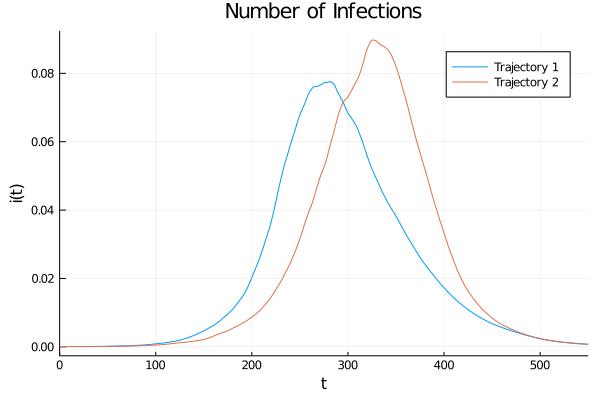

In [7]:
sol_2 = solve(prob, SOSRI())
plot(sol_1, vars=[2], title = "Number of Infections", label = "Trajectory 1",
     lm = 2, xlabel = "t", ylabel = "i(t)")
plot!(sol_2, vars=[2], label = "Trajectory 2", lm = 2, ylabel = "i(t)")

O mesmo vale para outras variáveis, como as mortes cumulativas, mortalidade e $ R_0 $:

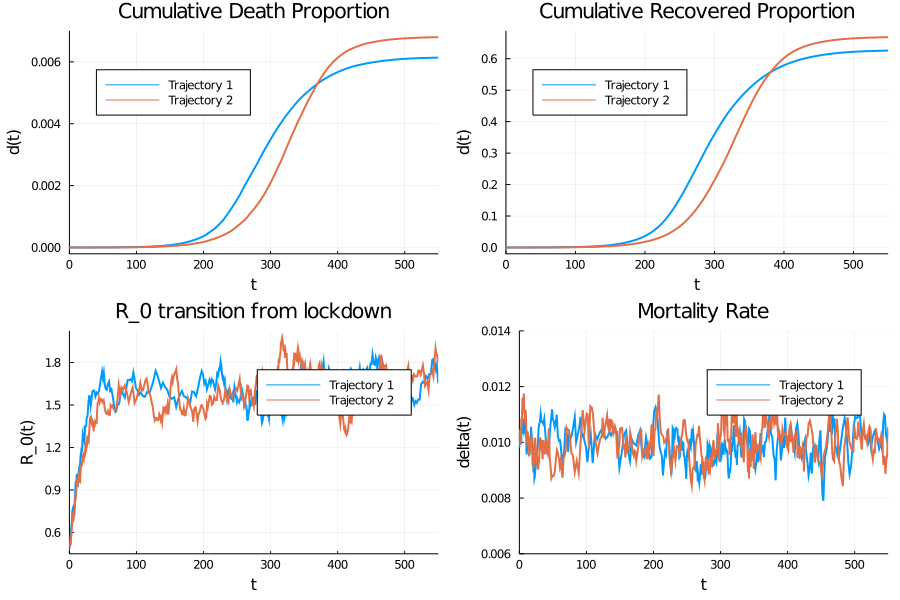

In [8]:
plot_1 = plot(sol_1, vars=[4], title = "Cumulative Death Proportion", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "d(t)", legend = :topleft)
plot!(plot_1, sol_2, vars=[4], label = "Trajectory 2", lw = 2)
plot_2 = plot(sol_1, vars=[3], title = "Cumulative Recovered Proportion", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "d(t)", legend = :topleft)
plot!(plot_2, sol_2, vars=[3], label = "Trajectory 2", lw = 2)
plot_3 = plot(sol_1, vars=[5], title = "R_0 transition from lockdown", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "R_0(t)")
plot!(plot_3, sol_2, vars=[5], label = "Trajectory 2", lw = 2)
plot_4 = plot(sol_1, vars=[6], title = "Mortality Rate", label = "Trajectory 1",
              lw = 2, xlabel = "t", ylabel = "delta(t)", ylim = (0.006, 0.014))
plot!(plot_4, sol_2, vars=[6], label = "Trajectory 2", lw = 2)
plot(plot_1, plot_2, plot_3, plot_4, size = (900, 600))

Veja [aqui](https://diffeq.sciml.ai/stable/solvers/sde_solve/#Recommended-Methods-1) os comentários sobre como encontrar o algoritmo SDE apropriado dada a estrutura de $ F (x, t) $ e $ G (x, t) $:

- Se $ G $ tem ruído diagonal (ou seja, $ G (x, t) $ é diagonal e possivelmente uma função do estado), então `SOSRI` é a escolha típica.
- Se $ G $ tem aditivo (ou seja, $ G (t) $ é independente do estado), então `SOSRA` é geralmente o melhor algoritmo para $ F $ ligeiramente rígidos.
- Se o processo de ruído for mais geral, `LambaEM` e` RKMilGeneral` são flexíveis para todos os processos de ruído.
- Se a alta precisão e adaptabilidade não forem necessárias, então o ʻEM` (ou seja, o método de Euler-Maruyama normalmente usado por economistas) é flexível em sua capacidade de lidar com diferentes processos de ruído.

### Conjuntos

Embora as simulações individuais sejam úteis, você geralmente deseja observar um conjunto de trajetórias do SDE para obter uma imagem precisa de como o sistema evolui.

Para fazer isso, use o `EnsembleProblem` para que a solução calcule várias trajetórias de uma vez. O retornado `EnsembleSolution` atua como uma matriz de soluções, mas é imbuído para traçar receitas para mostrar quantidades agregadas.

Por exemplo:

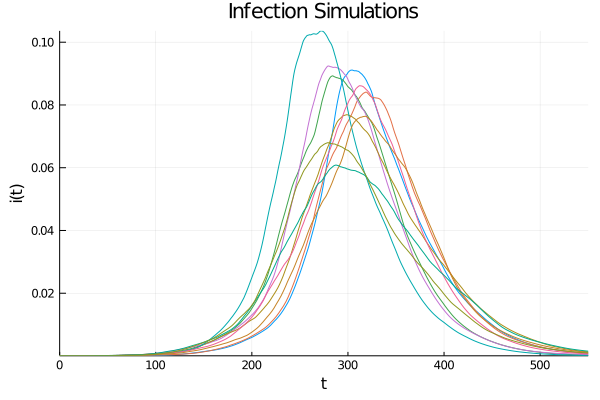

In [9]:
ensembleprob = EnsembleProblem(prob)
sol = solve(ensembleprob, SOSRI(), EnsembleSerial(), trajectories = 10)
plot(sol, vars = [2], title = "Infection Simulations", ylabel = "i(t)", xlabel = "t", lm = 2)

Ou, mais frequentemente, você pode querer executar muitas trajetórias e plotar quantis, que podem ser executados automaticamente em [paralelo](https://docs.sciml.ai/stable/features/ensemble/) usando vários threads, processos ou GPUs. Aqui, mostramos o `EnsembleSummary`, que calcula informações resumidas de um conjunto e traça a média da solução junto com os quantis calculados da simulação:

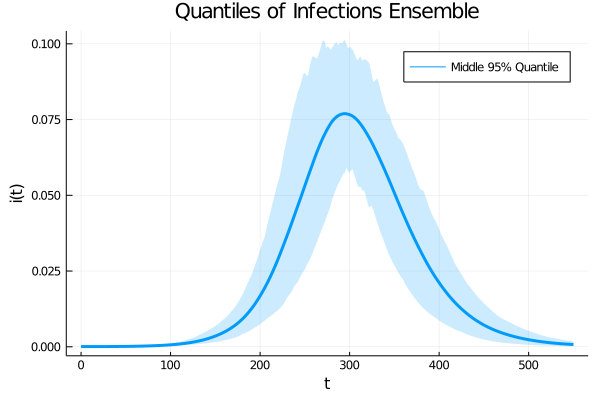

In [10]:
trajectories = 100  # escolha maior para quantis mais suaves
sol = solve(ensembleprob, SOSRI(), EnsembleThreads(), trajectories = trajectories)
summ = EnsembleSummary(sol) # defaults to saving 0.05, 0.95 quantiles
plot(summ, idxs = (2,), title = "Quantiles of Infections Ensemble", ylabel = "i(t)",
     xlabel = "t", labels = "Middle 95% Quantile", legend = :topright)

Além disso, você pode calcular mais quantis e gráficos de pilha:

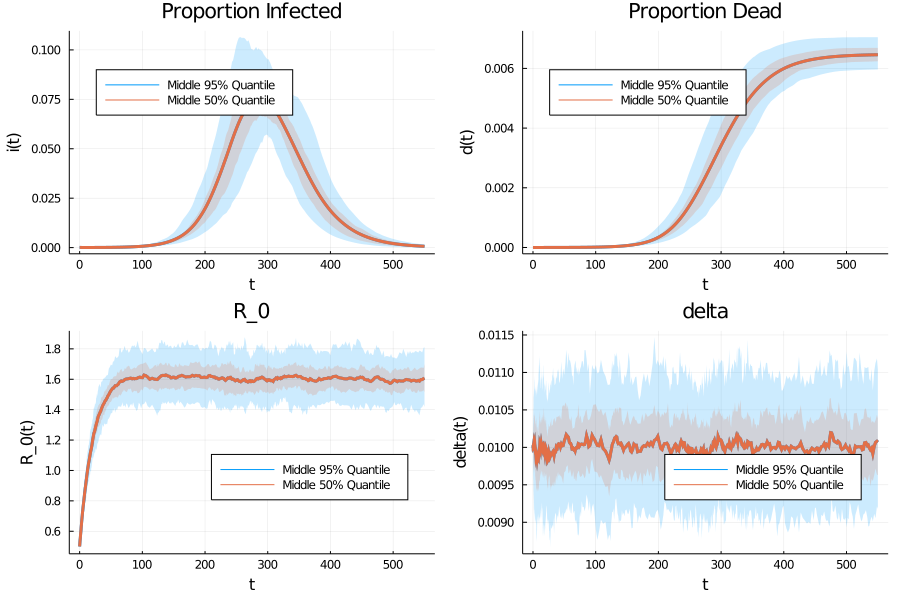

In [11]:
sol = solve(ensembleprob, SOSRI(), EnsembleThreads(), trajectories = trajectories)
summ = EnsembleSummary(sol) # o padrão é salvar 0,05, 0,95 quantis
summ2 = EnsembleSummary(sol, quantiles = (0.25, 0.75))

plot(summ, idxs = (2,4,5,6),
    title = ["Proportion Infected" "Proportion Dead" "R_0" "delta"],
    ylabel = ["i(t)" "d(t)" "R_0(t)" "delta(t)"], xlabel = "t",
    legend = [:topleft :topleft :bottomright :bottomright],
    labels = "Middle 95% Quantile", layout = (2, 2), size = (900, 600))
plot!(summ2, idxs = (2,4,5,6),
    labels = "Middle 50% Quantile", legend =  [:topleft :topleft :bottomright :bottomright])

Alguns recursos adicionais do conjunto e da infraestrutura SDE são:

- [Plotagem](https://diffeq.sciml.ai/stable/basics/plot/)
- [Processos de ruído](https://diffeq.sciml.ai/stable/features/noise_process/), [Ruído não diagonal](https://diffeq.sciml.ai/stable/tutorials/sde_example/#Example-4:-Systems-of-SDEs-with-Non-Diagonal-Noise-1), e [Ruído Correlato](https://diffeq.sciml.ai/stable/tutorials/sde_example/#Example:-Spatially-Colored-Noise-in-the-Heston-Model-1)
- [Recursos do Parallel Ensemble](https://diffeq.sciml.ai/stable/features/ensemble/)
- Transformar os cálculos do conjunto com um [função resposta ou redução](https://diffeq.sciml.ai/stable/features/ensemble/#Building-a-Problem-1)
- Auto-GPU acelerado usando `EnsembleGPUArray ()` de [DiffEqGPU](https://github.com/SciML/DiffEqGPU.jl/).

### Mudando a mitigação

Considere um formulador de políticas que deseja considerar o impacto de relaxar o bloqueio em várias velocidades.

Fecharemos os choques na taxa de mortalidade (ou seja, $ \ xi = 0 $) para focar na variação causada pela volatilidade em $ R_0 (t) $.

Considere $ \eta = 1/50 $ e $ \eta = 1/20 $, onde partimos da mesma condição inicial de $ R_0 (0) = 0,5 $.

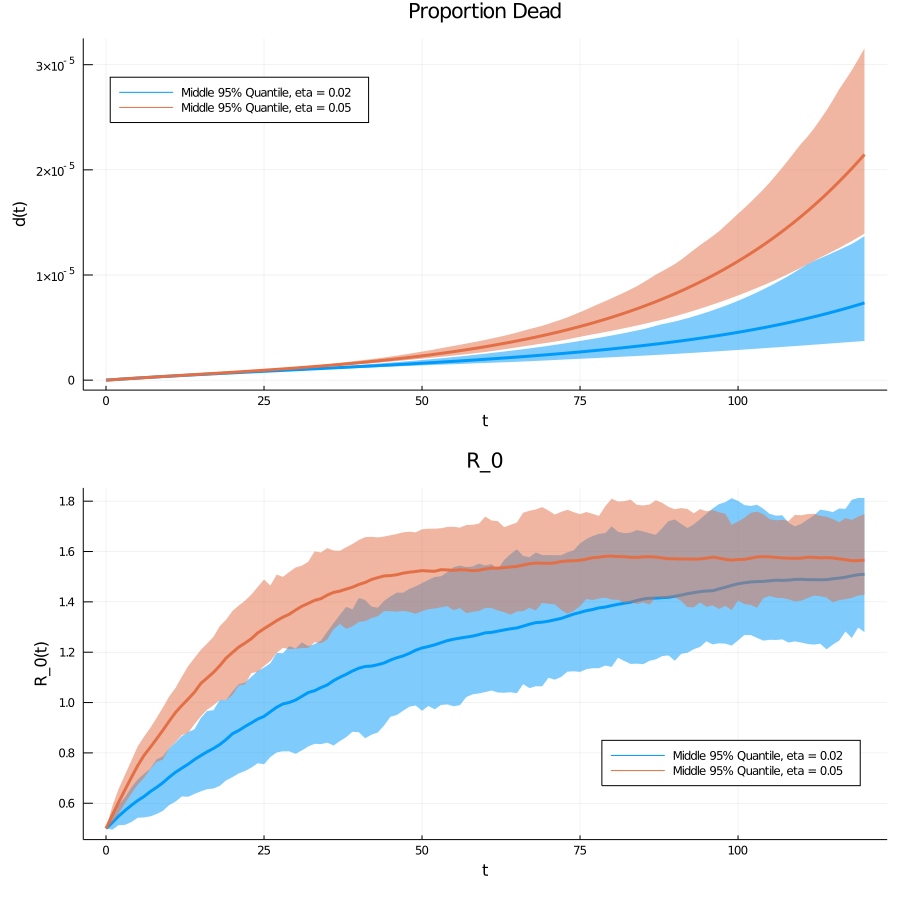

In [12]:
function generate_η_experiment(η; p_gen = p_gen, trajectories = 100,
                              saveat = 1.0, x_0 = x_0, T = 120.0)
    p = p_gen(η = η, ξ = 0.0)
    ensembleprob = EnsembleProblem(SDEProblem(F, G, x_0, (0, T), p))
    sol = solve(ensembleprob, SOSRI(), EnsembleThreads(),
                trajectories = trajectories, saveat = saveat)
    return EnsembleSummary(sol)
end

# Avaliar dois cenários diferentes de lockdown 
η_1 = 1/50
η_2 = 1/20
summ_1 = generate_η_experiment(η_1)
summ_2 = generate_η_experiment(η_2)
plot(summ_1, idxs = (4,5),
    title = ["Proportion Dead" "R_0"],
    ylabel = ["d(t)" "R_0(t)"], xlabel = "t",
    legend = [:topleft :bottomright],
    labels = "Middle 95% Quantile, eta = $η_1",
    layout = (2, 1), size = (900, 900), fillalpha = 0.5)
plot!(summ_2, idxs = (4,5),
    legend = [:topleft :bottomright],
    labels = "Middle 95% Quantile, eta = $η_2", size = (900, 900), fillalpha = 0.5)

Embora a média de $ d (t) $ aumente, sem surpresa, vemos que o quantil de 95% para períodos posteriores também é muito maior - mesmo depois de $ R_0 $ ter convergido.

Ou seja, taxas de contato voláteis (e, portanto, $ R_0 $) podem interagir para criar cenários catastróficos de pior caso devido à dinâmica não linear do sistema.

## Terminando o Lockdown

Como na aula determinística, podemos considerar dois cenários de mitigação:

1. A escolha $ \bar {R} _0 (t) $ para atingir $ R_0 = 0,5 $ por 30 dias e então $ R_0 = 2 $ para os 17 meses restantes. Isso corresponde ao levantamento do bloqueio em 30 dias, e
2. O alvo $ R_0 = 0,5 $ para 120 dias e, em seguida, $ R_0 = 2 $ para os 14 meses restantes. Isso corresponde ao levantamento do bloqueio em 4 meses.


Uma vez que as estimativas empíricas de $ R_0 (t) $ discutidas em [FVJ20](https://julia.quantecon.org/../zreferences.html#nberw27128) e outros artigos mostram que tem ampla variação, vamos manter um $ \sigma $ bastante maior.

Começamos o modelo com 100.000 infecções ativas.

In [13]:
R₀_L = 0.5  # lockdown
η_experiment = 1.0/10
σ_experiment = 0.04
R̄₀_lift_early(t, p) = t < 30.0 ? R₀_L : 2.0
R̄₀_lift_late(t, p) = t < 120.0 ? R₀_L : 2.0

p_early = p_gen(R̄₀ = R̄₀_lift_early, η = η_experiment, σ = σ_experiment)
p_late = p_gen(R̄₀ = R̄₀_lift_late, η = η_experiment, σ = σ_experiment)


# condições iniciais
i_0 = 100000 / p_early.N
r_0 = 0.0
d_0 = 0.0
s_0 = 1.0 - i_0 - r_0 - d_0
δ_0 = p_early.δ_bar

x_0 = [s_0, i_0, r_0, d_0, R₀_L, δ_0]  # começando o lockdown
prob_early = SDEProblem(F, G, x_0, (0, p_early.T), p_early)
prob_late = SDEProblem(F, G, x_0, (0, p_late.T), p_late)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: false
timespan: (0.0, 550.0)
u0: [0.9996969696969698, 0.00030303030303030303, 0.0, 0.0, 0.5, 0.01]

Simulando para uma única realização dos choques, vemos que os resultados são qualitativamente semelhantes ao que tínhamos antes:

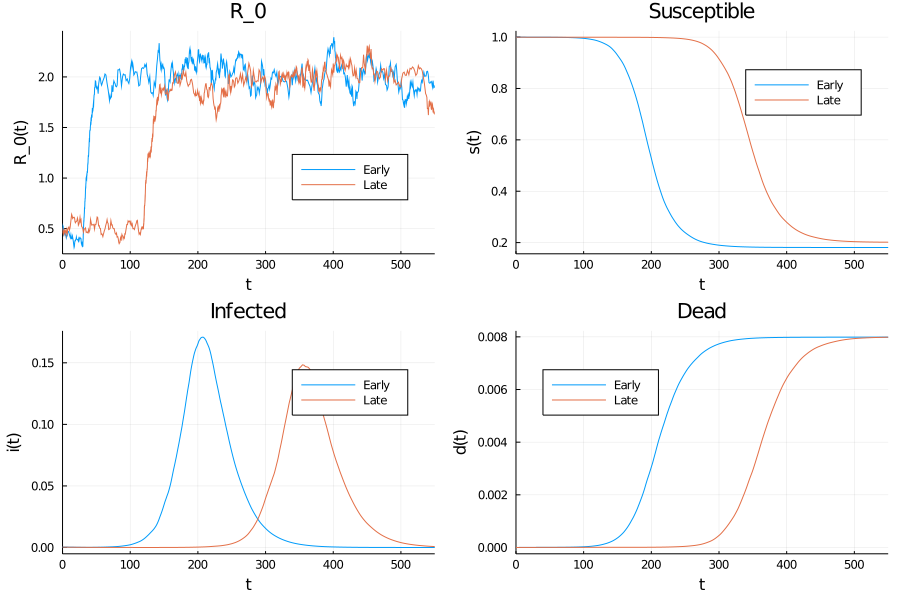

In [14]:
sol_early = solve(prob_early, SOSRI())
sol_late = solve(prob_late, SOSRI())
plot(sol_early, vars = [5, 1,2,4],
    title = ["R_0" "Susceptible" "Infected" "Dead"],
    layout = (2, 2), size = (900, 600),
    ylabel = ["R_0(t)" "s(t)" "i(t)" "d(t)"], xlabel = "t",
        legend = [:bottomright :topright :topright :topleft],
        label = ["Early" "Early" "Early" "Early"])
plot!(sol_late, vars = [5, 1,2,4],
        legend = [:bottomright :topright :topright :topleft],
        label = ["Late" "Late" "Late" "Late"])

No entanto, observe que isso mascara valores altamente voláteis induzidos pela variação em $ R_0 $, como visto no conjunto:

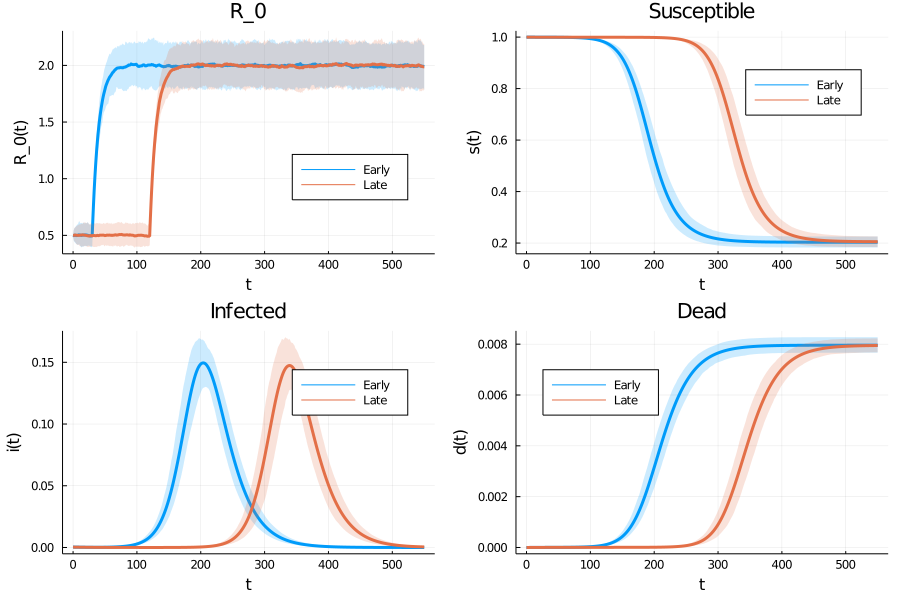

In [15]:
trajectories = 400
saveat = 1.0
ensemble_sol_early = solve(EnsembleProblem(prob_early), SOSRI(),
                           EnsembleThreads(), trajectories = trajectories, saveat = saveat)
ensemble_sol_late = solve(EnsembleProblem(prob_late), SOSRI(),
                          EnsembleThreads(), trajectories = trajectories, saveat = saveat)
summ_early = EnsembleSummary(ensemble_sol_early)
summ_late = EnsembleSummary(ensemble_sol_late)

plot(summ_early, idxs = (5, 1, 2, 4),
    title = ["R_0" "Susceptible" "Infected" "Dead"], layout = (2, 2), size = (900, 600),
    ylabel = ["R_0(t)" "s(t)" "i(t)" "d(t)"], xlabel = "t",
    legend = [:bottomright :topright :topright :topleft],
    label = ["Early" "Early" "Early" "Early"])
plot!(summ_late, idxs = (5, 1,2,4),
    legend = [:bottomright :topright :topright :topleft],
    label = ["Late" "Late" "Late" "Late"])

Finalmente, em vez de olhar para o resumo do conjunto, podemos usar os dados diretamente do conjunto para fazer nossa própria análise.

Por exemplo, avaliando em uma etapa intermediária (`t = 350`) e final.

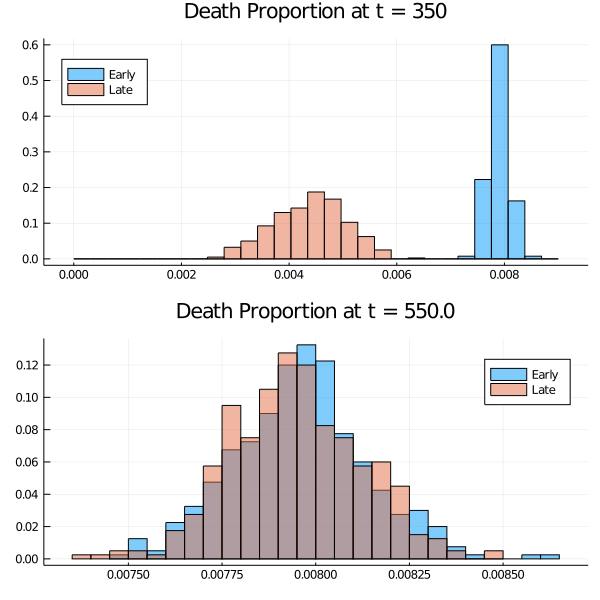

In [16]:
N = p_early.N
t_1 = 350
t_2 = p_early.T  # o último elemento
bins_1 = range(0.000, 0.009, length = 30)
bins_2 = 30  # número ao invés de grade

hist_1 = histogram([ensemble_sol_early.u[i](t_1)[4] for i in 1:trajectories],
                   fillalpha = 0.5, normalize = :probability,
                   legend = :topleft, bins = bins_1,
                   label = "Early", title = "Death Proportion at t = $t_1")
histogram!(hist_1, [ensemble_sol_late.u[i](t_1)[4] for i in 1:trajectories],
           label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_1)
hist_2 = histogram([ensemble_sol_early.u[i][4, end] for i in 1:trajectories],
                   fillalpha = 0.5, normalize = :probability, bins = bins_2,
                   label = "Early", title = "Death Proportion at t = $t_2")
histogram!(hist_2, [ensemble_sol_late.u[i][4, end] for i in 1:trajectories],
           label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_2)
plot(hist_1, hist_2, size = (600,600), layout = (2, 1))

Isso mostra que há diferenças significativas após um ano, mas em 550 dias os gráficos coincidem amplamente.

No código acima dado o retorno de `solve` em um `EnsembleProblem`, por exemplo, `Ensemble_sol = solve (...) `

- Você pode acessar a i'ésima simulação como `ensemble_sol [i]`, que tem todos os recursos padrão para a [solução de manipulação](https://diffeq.sciml.ai/stable/basics/solution/);
- Você pode avaliar em um período de tempo real, `t`, com `ensemble_sol [i] (t)`. Ou acesse o 4º elemento com `ensemble_sol [i] (t) [4] `;
- Se o `t` não era exatamente um dos valores` saveat` (se especificado) ou os passos de tempo adaptativos (se não fosse), então ele usará interpolação
- Alternativamente, para acessar os resultados do ODE como uma grade exatamente nas etapas de tempo, onde `j` é o índice de etapa de tempo, use `ensemble_sol [i] [j]` ou o 4º elemento com `ensemble_sol [i] [4, j ] `
- Aviso: a menos que você tenha escolhido uma grade `saveat`, os passos de tempo não serão alinhados entre as simulações. Ou seja, `ensemble_sol [i_1] .t` não corresponderia a `ensemble_sol [i_2] .t`. Nesse caso, use a interpolação com `ensemble_sol [i_1] (t) `etc.

## Reinfecção

Como um experimento final, considere um modelo em que a imunidade é apenas temporária e os indivíduos se tornam suscetíveis novamente.

Em particular, suponha que, à taxa de $ \nu $, a imunidade seja perdida. Para ilustração, examinaremos o caso se a imunidade média durar 12 meses (ou seja, $ 1 / \nu = 360 $)

A transição modifica a equação diferencial [(1)](#equation-sird) para se tornar


<a id='equation-sirdre'> </a>
$$
\begin {aligned}
      d s & = \left (- \gamma \, R_0 \, s \, i + \nu \, r \right) dt
      \\
       d i & = \left (\gamma \, R_0 \, s \, i - \gamma i \right) dt
      \\
      d r & = \left ((1- \delta) \gamma i - \nu \, r \right) dt
      \\
      d d & = \delta \gamma i \, dt
      \\
\end {aligned} \tag {6}
$$

Esta mudança modifica a função `F` subjacente e adiciona um parâmetro, mas caso contrário, o modelo permanece o mesmo.

Vamos refazer a simulação “Ending Lockdown” de cima, onde a única diferença é a nova transição.

In [17]:
function F_reinfect(x, p, t)
    s, i, r, d, R₀, δ = x
    @unpack γ, R̄₀, η, σ, ξ, θ, δ_bar, ν = p

    return [-γ*R₀*s*i + ν*r;  # ds/dt
            γ*R₀*s*i - γ*i;   # di/dt
            (1-δ)*γ*i - ν*r   # dr/dt
            δ*γ*i;            # dd/dt
            η*(R̄₀(t, p) - R₀);# dR₀/dt
            θ*(δ_bar - δ);    # dδ/dt
            ]
end

p_re_gen = @with_kw ( T = 550.0, γ = 1.0 / 18, η = 1.0 / 20,
                R₀_n = 1.6, R̄₀ = (t, p) -> p.R₀_n,
                δ_bar = 0.01, σ = 0.03, ξ = 0.004, θ = 0.2, N = 3.3E8, ν = 1/360)

p_re_early = p_re_gen(R̄₀ = R̄₀_lift_early, η = η_experiment, σ = σ_experiment)
p_re_late = p_re_gen(R̄₀ = R̄₀_lift_late, η = η_experiment, σ = σ_experiment)

trajectories = 400
saveat = 1.0
prob_re_early = SDEProblem(F_reinfect, G, x_0, (0, p_re_early.T), p_re_early)
prob_re_late = SDEProblem(F_reinfect, G, x_0, (0, p_re_late.T), p_re_late)
ensemble_sol_re_early = solve(EnsembleProblem(prob_re_early), SOSRI(), EnsembleThreads(),
                              trajectories = trajectories, saveat = saveat)
ensemble_sol_re_late = solve(EnsembleProblem(prob_re_late), SOSRI(), EnsembleThreads(),
                              trajectories = trajectories, saveat = saveat)
summ_re_early = EnsembleSummary(ensemble_sol_re_early)
summ_re_late = EnsembleSummary(ensemble_sol_re_late)

EnsembleSolution Solution of length 551 with uType:
Float64

As simulações de conjunto para $ \nu = 0 $ e $ \nu> 0 $ podem ser comparadas para ver o impacto na ausência de inovações médicas.

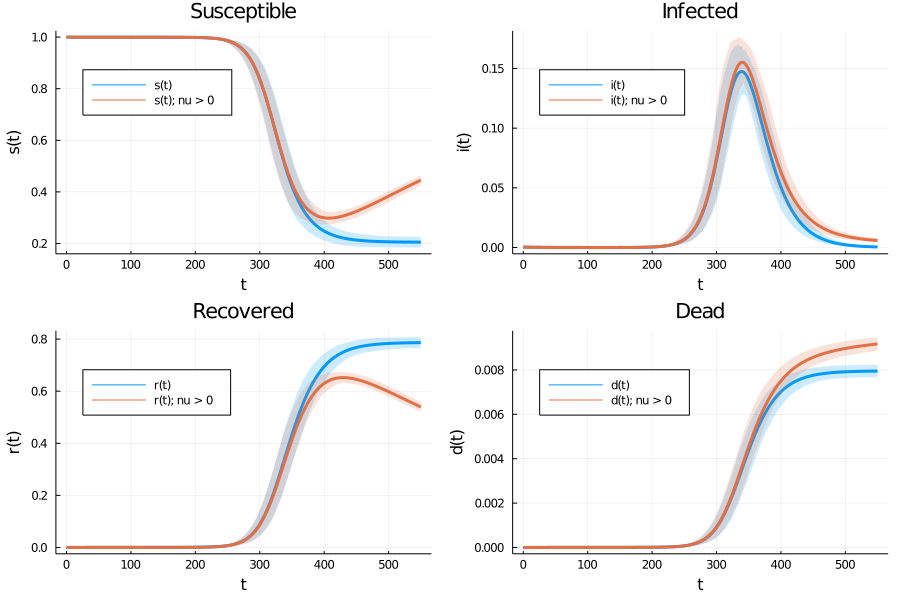

In [18]:
plot(summ_late, idxs = (1, 2, 3, 4),
    title = ["Susceptible" "Infected" "Recovered" "Dead"],
    layout = (2, 2), size = (900, 600),
    ylabel = ["s(t)" "i(t)" "r(t)" "d(t)"], xlabel = "t",
    legend = :topleft,
    label = ["s(t)" "i(t)" "r(t)" "d(t)"])
plot!(summ_re_late, idxs =  (1, 2, 3, 4),
    legend = :topleft,
    label = ["s(t); nu > 0" "i(t); nu > 0" "r(t); nu > 0" "d(t); nu > 0"])

Finalmente, podemos examinar o mesmo histograma de bloqueio inicial vs. tardio:

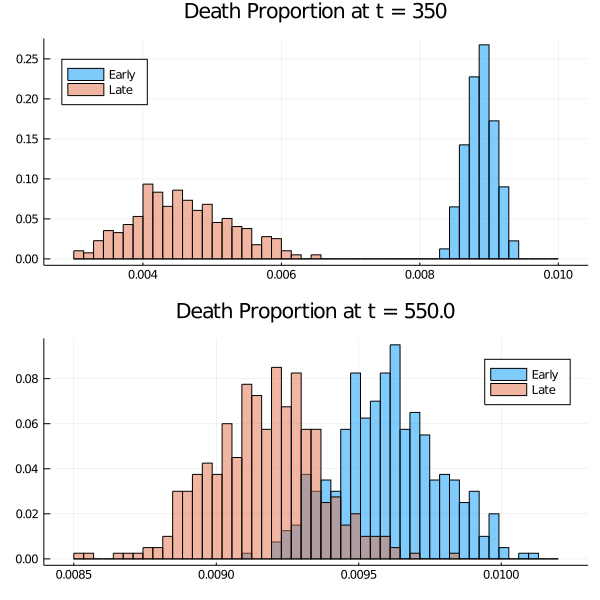

In [19]:
bins_re_1 = range(0.003, 0.010, length = 50)
bins_re_2 = range(0.0085, 0.0102, length = 50)
hist_re_1 = histogram([ensemble_sol_re_early.u[i](t_1)[4] for i in 1:trajectories],
                    fillalpha = 0.5, normalize = :probability,
                    legend = :topleft, bins = bins_re_1,
                    label = "Early", title = "Death Proportion at t = $t_1")
histogram!(hist_re_1, [ensemble_sol_re_late.u[i](t_1)[4] for i in 1:trajectories],
        label = "Late", fillalpha = 0.5, normalize = :probability, bins = bins_re_1)
hist_re_2 = histogram([ensemble_sol_re_early.u[i][4, end] for i in 1:trajectories],
                    fillalpha = 0.5, normalize = :probability, bins = bins_re_2,
                    label = "Early", title = "Death Proportion at t = $t_2")
histogram!(hist_re_2, [ensemble_sol_re_late.u[i][4, end] for i in 1:trajectories],
        label = "Late", fillalpha = 0.5, normalize = :probability,
        bins =  bins = bins_re_2)
plot(hist_re_1, hist_re_2, size = (600,600), layout = (2, 1))

Nesse caso, há diferenças significativas entre as mortes precoces e tardias e alta variância.

Esta simulação desanimadora presumiu que nenhum indivíduo tem imunidade de longo prazo e que não haverá avanços médicos nesse horizonte de tempo - ambos os quais provavelmente não serão verdadeiros.

No entanto, sugere que o momento do levantamento do bloqueio tem um impacto mais profundo após 18 meses, se permitirmos a imunidade imperfeita a choques estocásticos.